# CIFAR10-embeddings dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: CIFAR10-embeddings
- Model: Pretrained ResNet50 + LogisticRegression
- Metric: Classification accuracy

In [2]:
dataset_name = "cifar10-embeddings"
train_count, valid_count, test_count = 500, 100, 300
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch (sklearn's logistic regression can be very slow).
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
device = torch.device("cuda")

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.5666666626930237


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley ## slow
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley ## slow
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.28it/s]


Elapsed time LeaveOneOut(): 0:00:12.461077


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.86it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:15.913811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 129.90it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:15.468053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 10954.97it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.074117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.14it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:11.897906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.66it/s]


Elapsed time AME(num_models=1000): 0:00:46.379092


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.62it/s]


Elapsed time DataOob(num_models=1000): 0:00:22.930267


Elapsed time LavaEvaluator(): 0:00:00.583581
CPU times: user 2min 2s, sys: 260 ms, total: 2min 2s
Wall time: 2min 5s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/cifar10-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.061538
DVRL(rl_epochs=2000),0.054054
DataBanzhaf(num_models=1000),0.166113
DataOob(num_models=1000),0.318182
InfluenceFunctionEval(num_models=1000),0.173333
KNNShapley(k_neighbors=100),0.242623
LavaEvaluator(),0.148649
LeaveOneOut(),0.188586
RandomEvaluator(),0.160279


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

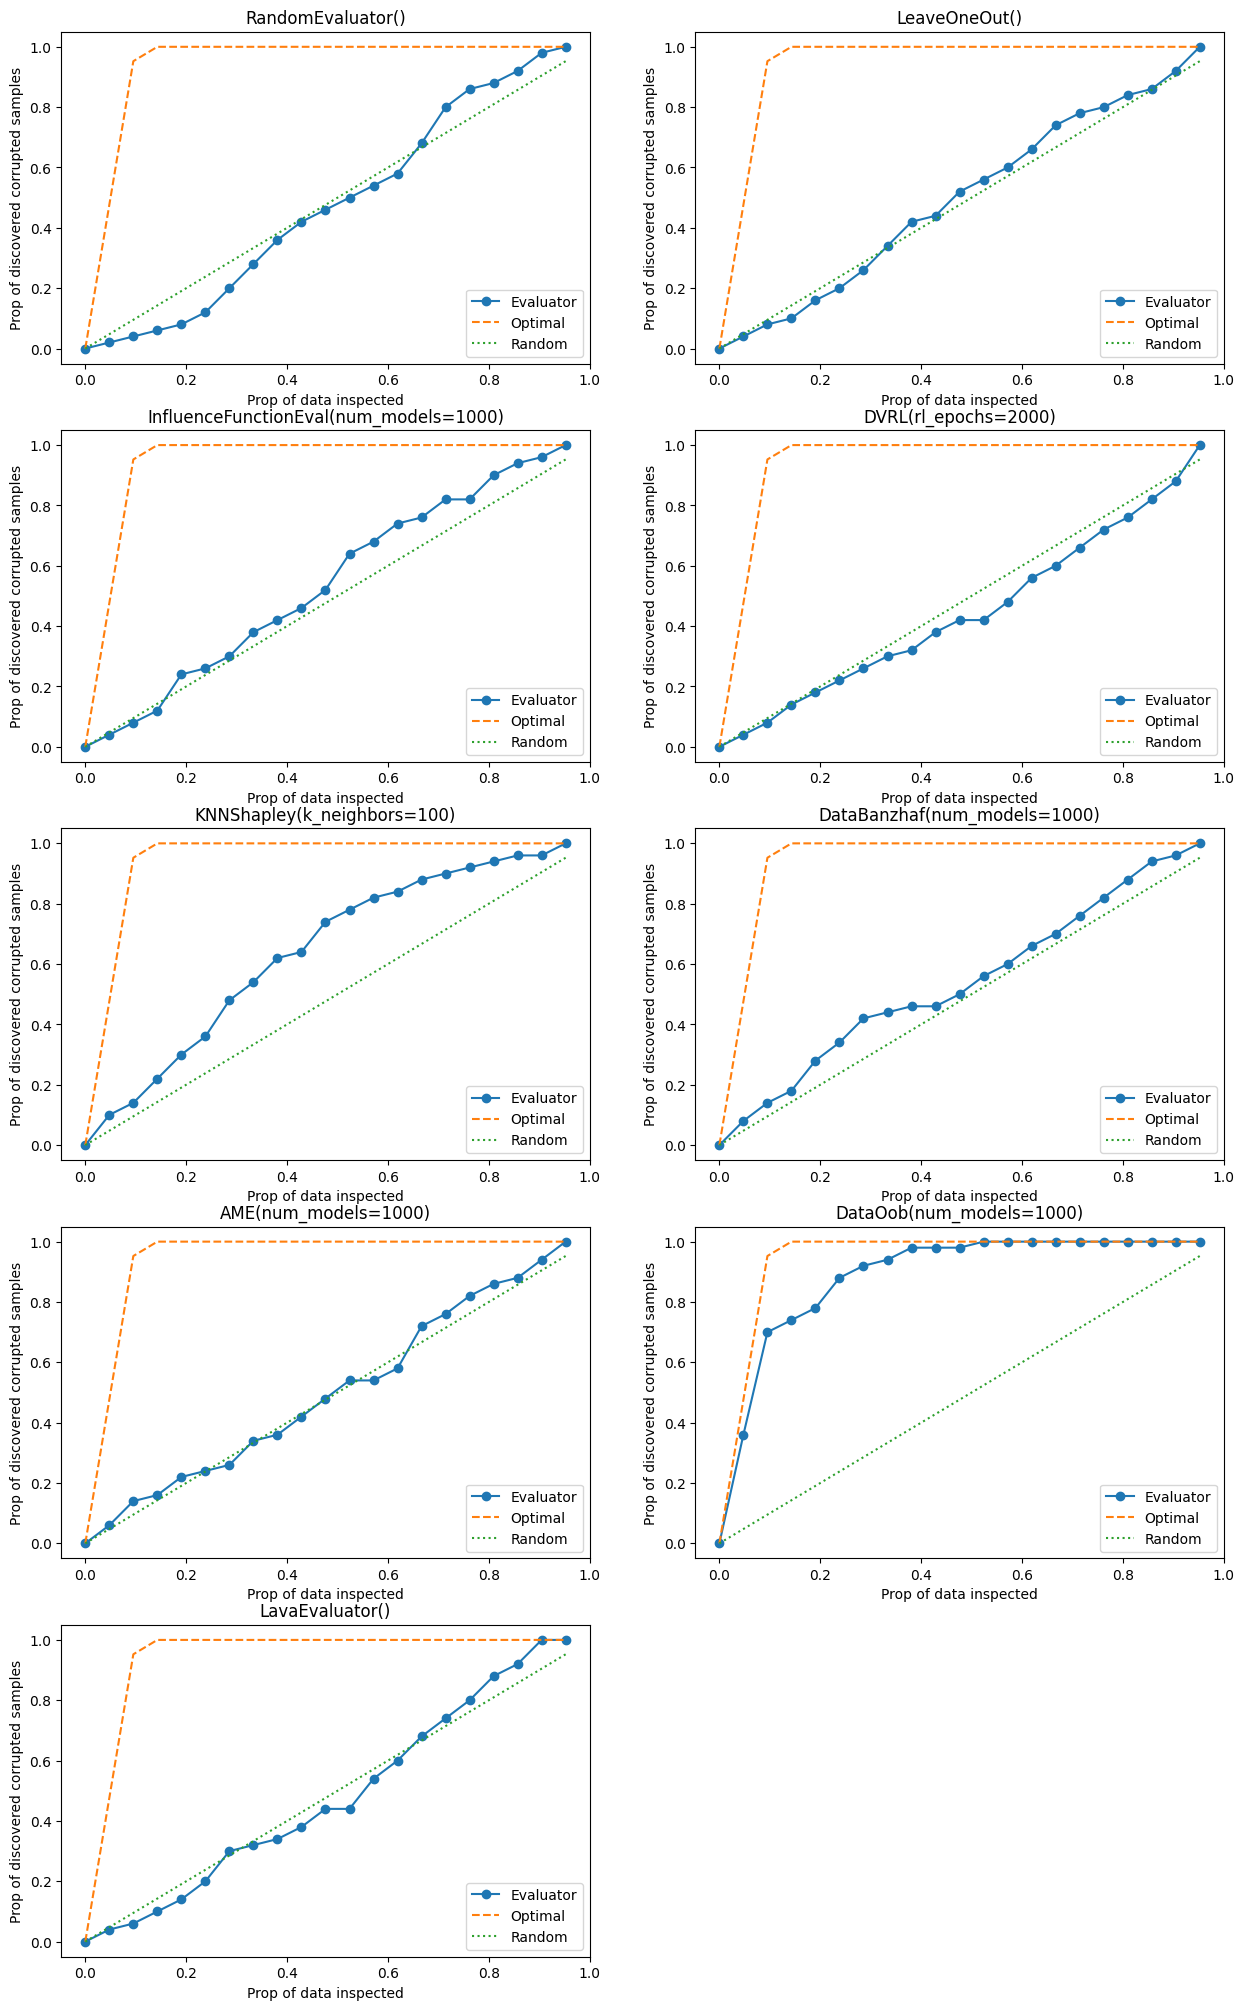

In [7]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

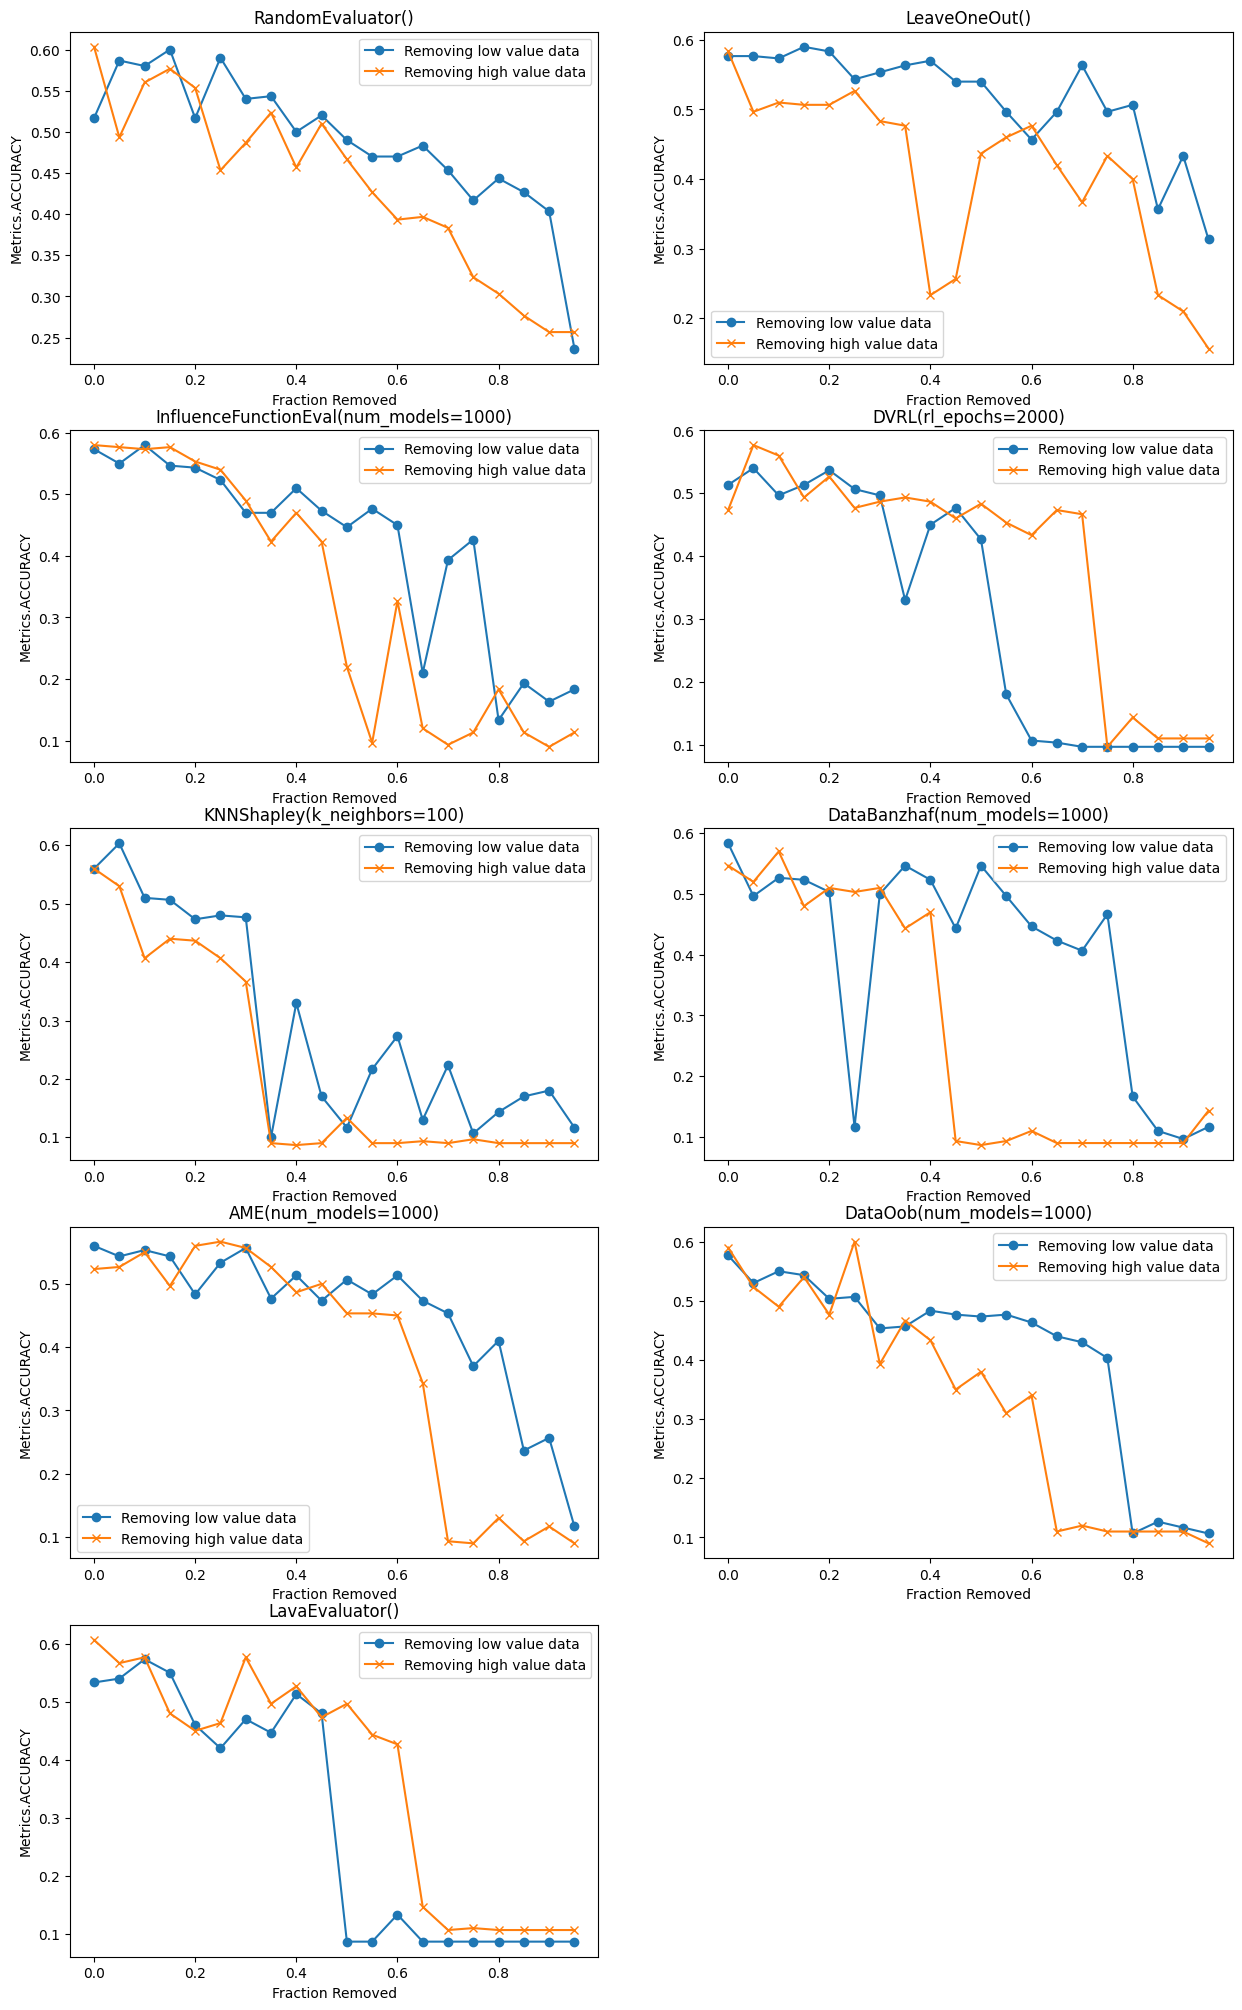

In [8]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.516667,0.603333,0.0
RandomEvaluator(),0.586667,0.493333,0.05
RandomEvaluator(),0.58,0.56,0.1
RandomEvaluator(),0.6,0.576667,0.15
RandomEvaluator(),0.516667,0.553333,0.2
...,...,...,...
LavaEvaluator(),0.086667,0.11,0.75
LavaEvaluator(),0.086667,0.106667,0.8
LavaEvaluator(),0.086667,0.106667,0.85
LavaEvaluator(),0.086667,0.106667,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),1261,0.532184
RandomEvaluator(),18871,0.608089
RandomEvaluator(),45617,0.510269
RandomEvaluator(),13031,0.798323
RandomEvaluator(),4007,0.536161
...,...,...
LavaEvaluator(),43619,5.602806
LavaEvaluator(),22191,-2.200794
LavaEvaluator(),3223,-3.603848
LavaEvaluator(),22451,0.865791
